<a href="https://colab.research.google.com/github/Rapurva/Financial-Trials/blob/master/Sentiment_analysis_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [16]:
import pandas as pd
import numpy as np

import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests

stock = 'HDFCBANK.NS'

def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']
company_name = get_symbol(stock)

data_TCS = pdr.get_data_yahoo(stock, '01-APR-20') 
data_TCS.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-18,888.000000,831.299988,888.000000,836.650024,23324982,836.650024
2020-05-19,867.299988,826.099976,860.849976,830.650024,23730346,830.650024
2020-05-20,864.000000,832.200012,836.450012,857.099976,20007153,857.099976
2020-05-21,884.000000,852.299988,861.450012,859.549988,24239454,859.549988
2020-05-22,870.299988,833.049988,850.000000,838.849976,21018473,838.849976


In [0]:
data_TCS['2_SMA'] = data_TCS['Close'].rolling(window=2).mean()
data_TCS['5_SMA'] = data_TCS['Close'].rolling(window=5).mean()

data_TCS = data_TCS[data_TCS['5_SMA'].notna()]

In [18]:
# SMA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(data_TCS)-1):
    if ((data_TCS['2_SMA'].values[i] < data_TCS['5_SMA'].values[i]) & (data_TCS['2_SMA'].values[i+1] > data_TCS['5_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=data_TCS.index[i+1].date()))
        Trade_Buy.append(i+1)
    elif ((data_TCS['2_SMA'].values[i] > data_TCS['5_SMA'].values[i]) & (data_TCS['2_SMA'].values[i+1] < data_TCS['5_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=data_TCS.index[i+1].date()))
        Trade_Sell.append(i+1)

Trade Call for 2020-04-15 is Sell.
Trade Call for 2020-04-17 is Buy.
Trade Call for 2020-04-27 is Sell.
Trade Call for 2020-04-29 is Buy.
Trade Call for 2020-05-05 is Sell.
Trade Call for 2020-05-08 is Buy.
Trade Call for 2020-05-11 is Sell.
Trade Call for 2020-05-21 is Buy.


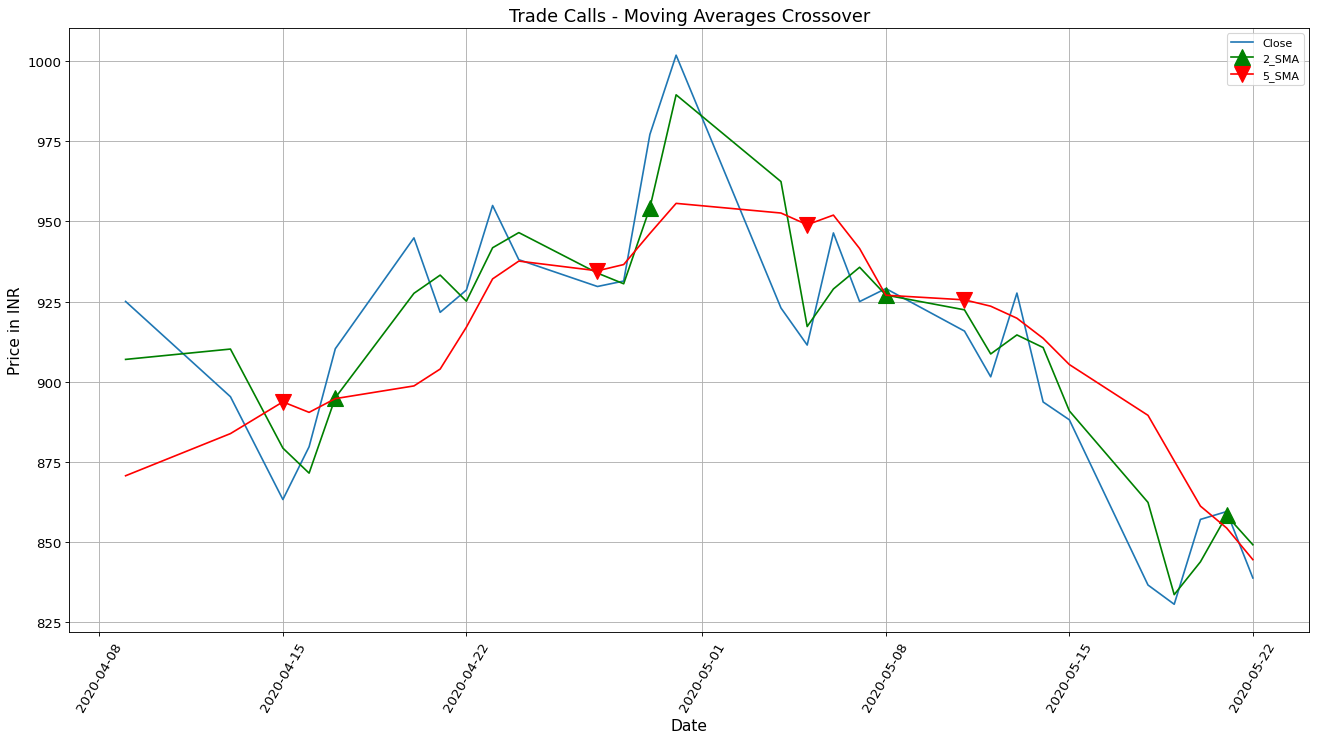

In [19]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_TCS.index, data_TCS['Close'])
plt.plot(data_TCS.index, data_TCS['2_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(data_TCS.index, data_TCS['5_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in INR', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - Moving Averages Crossover', fontsize = 16)
plt.legend(['Close','2_SMA','5_SMA'])
plt.grid()
plt.show() 

In [0]:
import requests 
# Define the endpoint
url = 'https://newsapi.org/v2/everything?'

# Specify the query and number of returns
parameters = {
    'q': company_name, # query phrase
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': '8733d8404bbe4181a8ab3ec459afb508', # your own API key
}

# Make the request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

final_news = news_df.loc[:,['publishedAt','title']]
final_news['publishedAt'] = pd.to_datetime(final_news['publishedAt'])
final_news.sort_values(by='publishedAt',inplace=True)

# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay

# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=00) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=00)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Apply the above function to get the trading time for each news headline
final_news["trading_time"] = final_news["publishedAt"].apply(get_trade_open)

final_news = final_news[pd.notnull(final_news['trading_time'])]
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)

In [21]:
final_news

,publishedAt,title,trading_time,Date
83,2020-04-23 13:26:19+00:00,"Sensex rises 483 points, Nifty at 9,313 as oil...",2020-04-23 13:30:00+00:00,2020-04-23
40,2020-04-24 03:37:00+00:00,Chris Wood rejigs India exposure; says lockdow...,2020-04-24 13:30:00+00:00,2020-04-24
96,2020-04-24 11:00:25+00:00,"Sensex slides 536 points, Nifty barely holds 9...",2020-04-24 13:30:00+00:00,2020-04-24
97,2020-04-25 03:56:44+00:00,"Franklin TempleRun: Panic spreads to AMCs, cor...",2020-04-27 13:30:00+00:00,2020-04-27
62,2020-04-25 03:56:44+00:00,"Franklin TempleRun: Panic spreads to AMCs, cor...",2020-04-27 13:30:00+00:00,2020-04-27
...,...,...,...,...
15,2020-05-22 08:41:29+00:00,Market stares at an uncertain tomorrow; 12 sto...,2020-05-22 13:30:00+00:00,2020-05-22
28,2020-05-22 09:35:29+00:00,RBI cuts repo rate by 40 bps: It is unexpected...,2020-05-22 13:30:00+00:00,2020-05-22
32,2020-05-22 11:11:00+00:00,"Sensex drops 260 points, Nifty settles below 9...",2020-05-22 13:30:00+00:00,2020-05-22
48,2020-05-23 08:28:01+00:00,Big Story | How Atmanirbhar Bharat impacts sec...,2020-05-25 13:30:00+00:00,2020-05-25


In [22]:
cs = []
for row in range(len(final_news)):
    cs.append(analyzer.polarity_scores(final_news['title'].iloc[row])['compound'])

final_news['compound_vader_score'] = cs
final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

final_news.head()

,publishedAt,title,trading_time,Date,compound_vader_score
0,2020-04-23 13:26:19+00:00,"Sensex rises 483 points, Nifty at 9,313 as oil...",2020-04-23 13:30:00+00:00,2020-04-23,0.4019
1,2020-04-24 03:37:00+00:00,Chris Wood rejigs India exposure; says lockdow...,2020-04-24 13:30:00+00:00,2020-04-24,-0.5994
2,2020-04-24 11:00:25+00:00,"Sensex slides 536 points, Nifty barely holds 9...",2020-04-24 13:30:00+00:00,2020-04-24,0.7096
3,2020-04-25 03:56:44+00:00,"Franklin TempleRun: Panic spreads to AMCs, cor...",2020-04-27 13:30:00+00:00,2020-04-27,-0.5106
4,2020-04-25 03:56:44+00:00,"Franklin TempleRun: Panic spreads to AMCs, cor...",2020-04-27 13:30:00+00:00,2020-04-27,-0.5106


In [0]:
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

In [24]:
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores

extreme_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-04-23,0.4019,0.0000,0.4019
1,2020-04-24,0.7096,-0.5994,0.1102
2,2020-04-27,0.4404,-0.5106,-0.0702
3,2020-04-28,0.7430,-0.2960,0.4470
4,2020-04-29,0.2023,-0.1027,0.0996


In [25]:
# VADER trade calls - with threshold
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

Trade Call for 2020-04-23 is Buy.
Trade Call for 2020-04-28 is Buy.
Trade Call for 2020-05-01 is Buy.
Trade Call for 2020-05-04 is Buy.
Trade Call for 2020-05-06 is Buy.
Trade Call for 2020-05-07 is Buy.
Trade Call for 2020-05-11 is Buy.
Trade Call for 2020-05-12 is Buy.
Trade Call for 2020-05-13 is Buy.
Trade Call for 2020-05-14 is Sell.
Trade Call for 2020-05-15 is Sell.
Trade Call for 2020-05-18 is Buy.
Trade Call for 2020-05-21 is Buy.


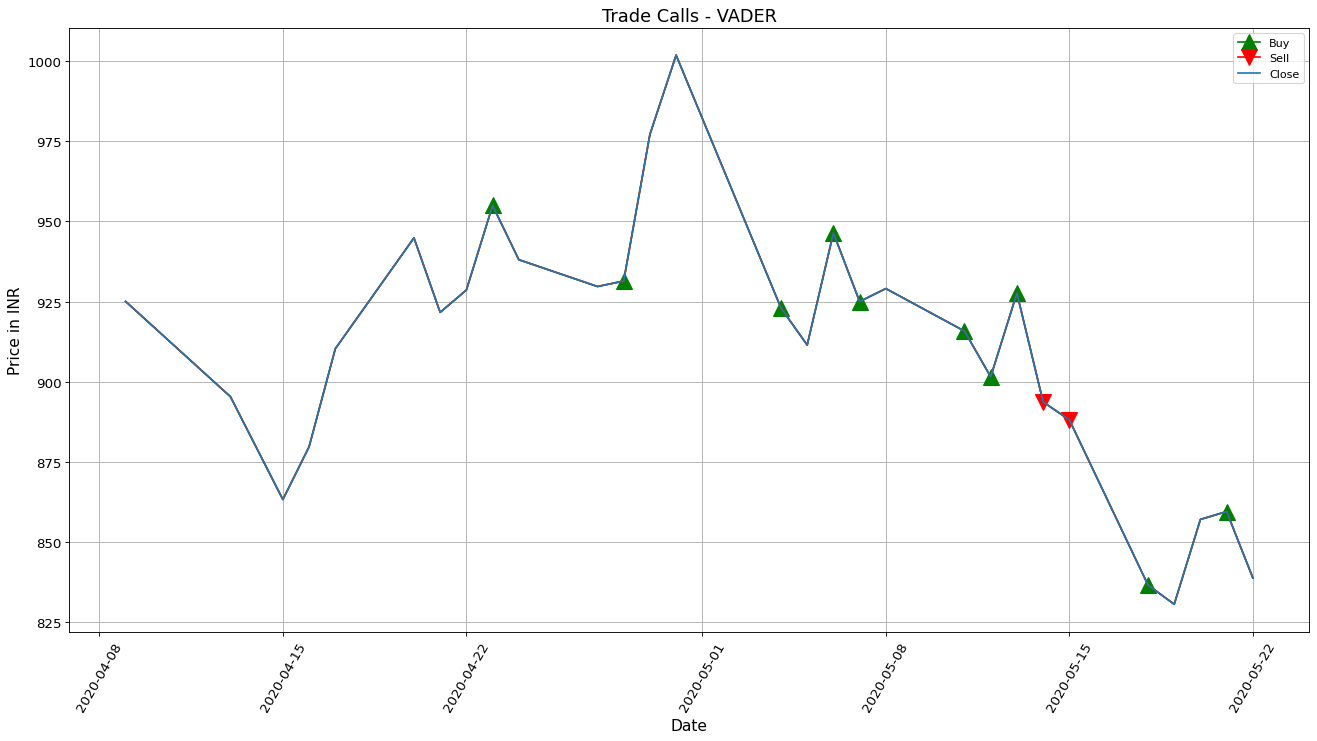

In [26]:
vader_buy = []
for i in range(len(data_TCS)):
    if data_TCS.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(data_TCS)):
    if data_TCS.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_TCS.index, data_TCS['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plt.plot(data_TCS.index, data_TCS['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plt.plot(data_TCS.index, data_TCS['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in INR', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

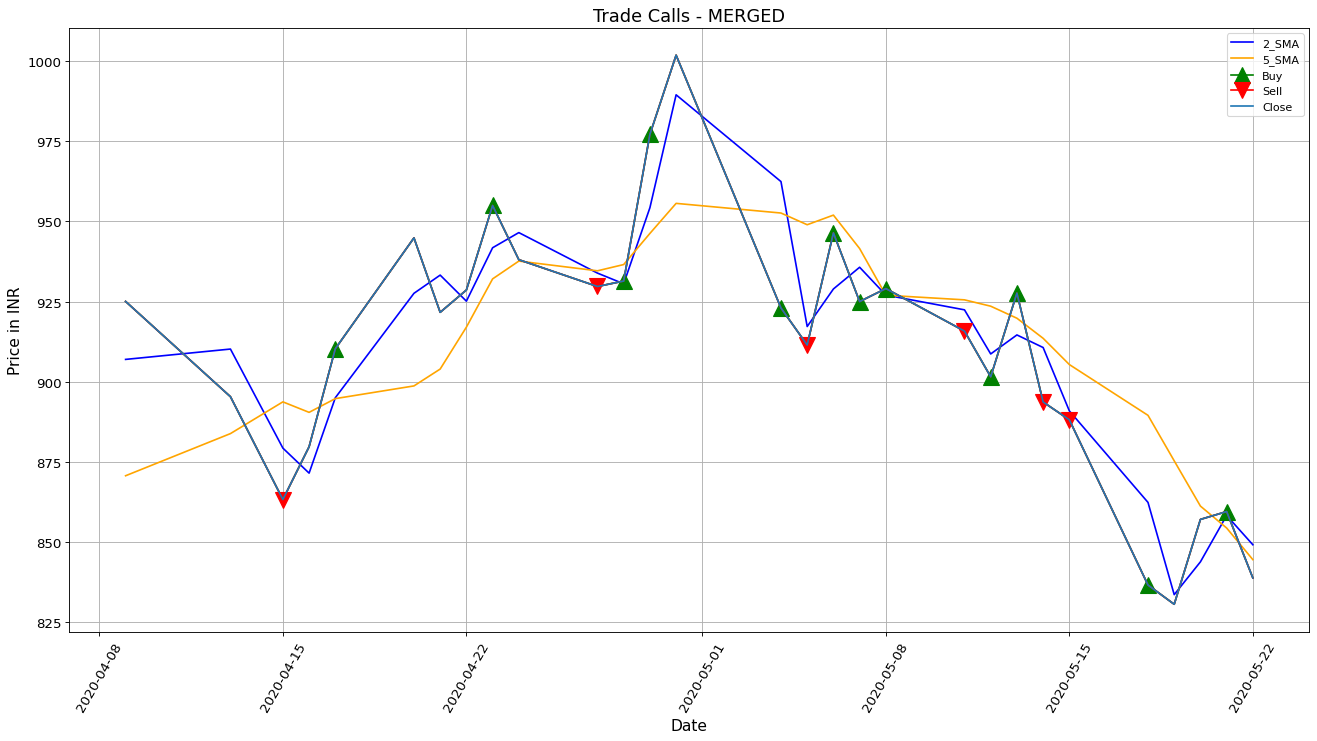

In [27]:
#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_TCS.index, data_TCS['2_SMA'], color='blue')
plt.plot(data_TCS.index, data_TCS['5_SMA'], color='orange')
plt.plot(data_TCS.index, data_TCS['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(data_TCS.index, data_TCS['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(data_TCS.index, data_TCS['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in INR', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show() 

In [28]:
 for i in range(len(data_TCS)):
   if i in final_buy:
     print("Trade Call for {row} is Buy.".format(row=data_TCS.index[i].date()))
   elif i in final_sell:
     print("Trade Call for {row} is Sell.".format(row=data_TCS.index[i].date()))

Trade Call for 2020-04-15 is Sell.
Trade Call for 2020-04-17 is Buy.
Trade Call for 2020-04-23 is Buy.
Trade Call for 2020-04-27 is Sell.
Trade Call for 2020-04-28 is Buy.
Trade Call for 2020-04-29 is Buy.
Trade Call for 2020-05-04 is Buy.
Trade Call for 2020-05-05 is Sell.
Trade Call for 2020-05-06 is Buy.
Trade Call for 2020-05-07 is Buy.
Trade Call for 2020-05-08 is Buy.
Trade Call for 2020-05-11 is Sell.
Trade Call for 2020-05-12 is Buy.
Trade Call for 2020-05-13 is Buy.
Trade Call for 2020-05-14 is Sell.
Trade Call for 2020-05-15 is Sell.
Trade Call for 2020-05-18 is Buy.
Trade Call for 2020-05-21 is Buy.
